# Hough 変換の実装

参考サイト: [ハフ変換で直線を検出する実装](https://qiita.com/ikuo0/items/c591b61fe8a07546688b)

## 必要パッケージを import

In [1]:
import os
import sys
sys.path.append("../../")

import inspect
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.ndimage
from PIL import Image, ImageOps

from src.config.config import cfg

%matplotlib inline

ModuleNotFoundError: No module named 'easydict'

## サンプル画像を作成

In [7]:
# 作成する画像サイズ
CANVAS_WIDTH = 300
CANVAS_HEIGHT = 200

def plotLine(dst, x1, y1, x2, y2, broken=1, variance=1):
    xd = x2 - x1
    yd = y2 - y1
    xsize = len(dst[0])
    ysize = len(dst)

    if xd == 0:
        if y1 > y2:
            y1, y2 = y2, y1
        for i in range(int(y1), int(y2), 1):
            dst[i][x1] = 1
        return

    if yd == 0:
        if x1 > x2:
            x1, x2 = x2, x1
        for i in range(int(x1), int(x2), 1):
            dst[y1][i] = 1
        return

    rad = math.atan2(yd, xd)
    distance = math.sqrt((xd ** 2) + (yd ** 2))
    for i in range(int(distance)):
        if broken >= 2 and not (i % broken) == 0: continue
        x = x1 + i * math.cos(rad)
        y = y1 + i * math.sin(rad)
        if variance > 0:
            x += int(random.random() * variance) - (variance / 2)
            y += int(random.random() * variance) - (variance / 2)
        if x < 0: x = 0
        if x >= xsize: x = xsize - 1
        if y < 0: y = 0
        if y >= ysize: y = ysize - 1
        dst[int(y)][int(x)] = 1


def createSampleImage(width, height):
    x = np.zeros((height, width)).astype(np.uint8)
    for i in range(4):
        x1 = int(random.uniform(0, CANVAS_WIDTH))
        y1 = int(random.uniform(0, CANVAS_HEIGHT))
        x2 = int(random.uniform(0, CANVAS_WIDTH))
        y2 = int(random.uniform(0, CANVAS_HEIGHT))
        plotLine(x, x1, y1, x2, y2, broken=0, variance=0)
    return x

shape= (200, 300)


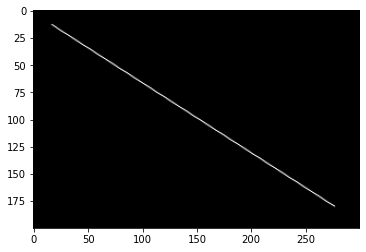

In [8]:
create_img = False # サンプル画像を作成するか
img_pth = os.path.join(cfg.HOUGH_IMG_DIR, "line.png")

if create_img:
    # 直線のサンプル画像を作成する
    random.seed(63)
    imageData = createSampleImage(CANVAS_WIDTH, CANVAS_HEIGHT)
else:
    imageData = Image.open(img_pth).convert('L').resize((CANVAS_WIDTH, CANVAS_HEIGHT))
    # ネガポジ反転
    imageData = ImageOps.invert(imageData)
    imageData = np.array(imageData) / 255

print('shape=', imageData.shape)
plt.imshow(imageData, cmap="gray")
plt.show()

## ハフ変換

<ipython-input-9-d6debf9b0fb0>:10: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if  not PX:
0.27058823529411763
PR [[  16.           16.206992     16.40904719 ...  -15.35004108
   -15.57145927  -15.78813425]
 [  17.           17.20683969   17.40843802 ...  -16.34867062
   -16.5708501   -16.78798194]
 [  16.           16.22444441   16.44394669 ...  -15.29770512
   -15.53655978  -15.77068184]
 ...
 [ 277.          280.08179231  283.07826899 ... -267.25224496
  -270.58424917 -273.83383081]
 [ 276.          279.09939702  282.11377766 ... -266.20127947
  -269.54995885 -272.8165307 ]
 [ 277.          280.09924472  283.11316849 ... -267.199909
  -270.54934968 -273.8163784 ]]


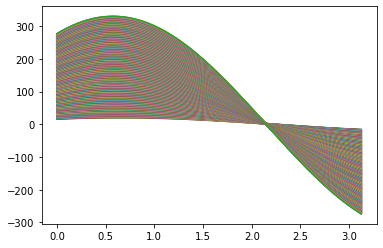

len(PX) 603
len(PY) 603
len(PR) 603
len(theta_arr) 180


In [9]:
def houghConvertSub(theta, x, y):
    distance = []
    for t in theta:
        d = x * math.cos(t) + y * math.sin(t)
        distance.append(d)
    return distance


PY, PX = np.where(imageData == 1) # # 値を持つピクセル座標の取得
if  not PX: 
    PY, PX = np.where(imageData != 0) # # 値を持つピクセル座標の取得

print(imageData.max())

DegreeDiscrete = 180 # pi をいくつに分割するか（粒度をどの程度にするか）、100とか200でも良い (分割数)
theta_arr = [math.pi * (i / DegreeDiscrete) for i in range(0, DegreeDiscrete)]
PR = []
for x, y in zip(PX, PY):
    p = houghConvertSub(theta_arr, x, y)
    PR.append(p)

PR = np.array(PR)

print('PR', PR)

plt.plot(theta_arr, PR.transpose())
#plt.savefig("./003_haough_convert.png")
plt.show()

print("len(PX)", len(PX))
print("len(PY)", len(PY))
print("len(PR)", len(PR))
print("len(theta_arr)", len(theta_arr))

vote.shape (722, 180)


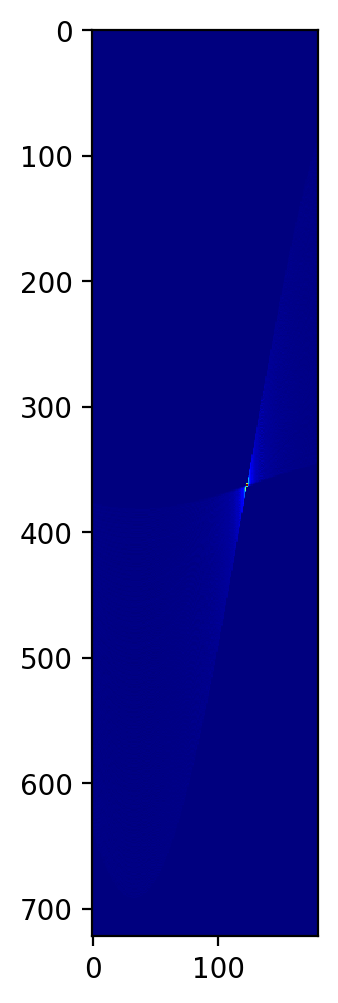

In [10]:
# 2次元配列にして交差している点をカウントする
# 対角線の長さを求め距離の最大値とする
diagonalDistance = math.sqrt((CANVAS_WIDTH ** 2) + (CANVAS_HEIGHT ** 2))
diagonalDistance = round(diagonalDistance)

# 交差点の交差数を投票する2次元配列を作成
vote = np.zeros((diagonalDistance * 2, len(theta_arr)))
print("vote.shape", vote.shape)
for P in PR:
    for x, p in enumerate(P):
        y = int(round(p))
        vote[y + diagonalDistance][x] += 1

# 標準化しておく
vote = (vote - np.mean(vote)) / np.std(vote)

plt.figure(figsize=(6,6),dpi=200)
plt.imshow(vote, cmap='jet', interpolation='nearest')
#plt.savefig("./004_haough_convert_vote.png")
plt.show()

newVote.shape (722, 190)


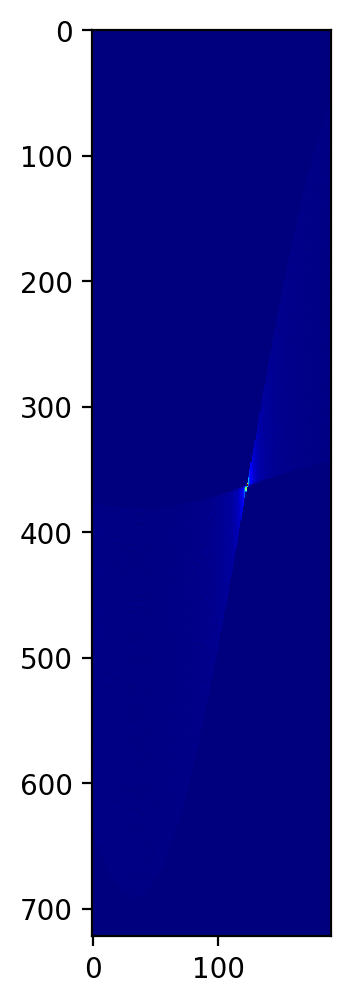

In [11]:
# 角度がループする都合上、先頭列と列の末尾はデータとしては連続している
# 列末尾に先頭列をいくつか追加しておく事で一括で処理できるよう準備する
appendMat = np.flipud(vote[:,:10])
newVote = np.c_[vote, appendMat]
print("newVote.shape", newVote.shape)

plt.figure(figsize=(6,6),dpi=200)
plt.imshow(newVote, cmap='jet', interpolation='nearest')
#plt.savefig("./005_haough_convert_vote_ex.png")
plt.show()

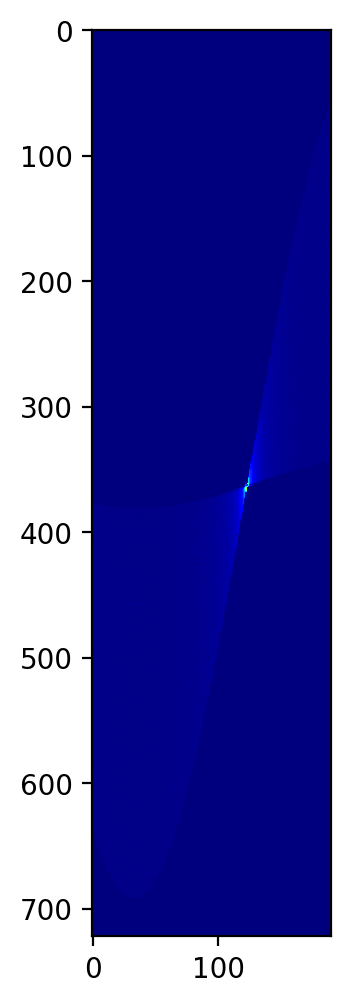

In [12]:
# ガウシアンフィルタをかけて頂点をできるだけ検出しやすくする
filteredVote = scipy.ndimage.gaussian_filter(newVote, sigma=0.5)
plt.figure(figsize=(6,6),dpi=200)
plt.imshow(filteredVote, cmap='jet', interpolation='nearest')
#plt.savefig("./006_haough_convert_vote_gaussian.png")
plt.show()

np.max(filteredVote) 89.25617226074716


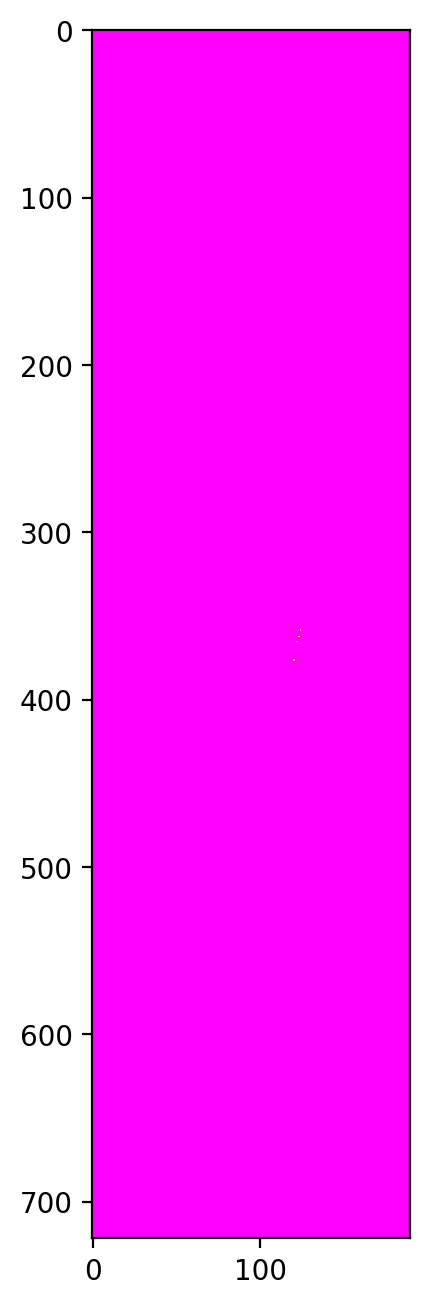

In [13]:
def detectPeak1D(x):
    conv1 = np.convolve(x, [1, -1], mode="full")
    flag1 = (conv1 > 0).astype(int)
    flag2 = (conv1 <= 0).astype(int)
    flag1 = flag1[:-1]
    flag2 = flag2[1:]
    flag3 = flag1 & flag2
    return flag3

def detectPeak2D(x):
    peaks1 = []
    for ix in x:
        peak = detectPeak1D(ix)
        peaks1.append(peak)
    peaks1 = np.array(peaks1)
    peaks2 = []
    for ix in x.transpose():
        peak = detectPeak1D(ix)
        peaks2.append(peak)
    peaks2 = np.array(peaks2).transpose()
    flag = (peaks1 & peaks2).astype(int)
    return flag

# ピーク検出を行う
# 誤検知については後の処理で投票数の少ない頂点を間引く事で対応する
peaks = detectPeak2D(filteredVote)
xidx, yidx = np.where(peaks == 1)
print("np.max(filteredVote)", np.max(filteredVote))
for x, y in zip(xidx, yidx):
    if filteredVote[x][y] > 10:
        peaks[x][y] = 1
    else:
        peaks[x][y] = 0

plt.figure(figsize=(8,8),dpi=200)
plt.imshow(peaks, cmap='spring', interpolation='nearest')
#plt.savefig("./007_haough_convert_peaks.png")
plt.show()

[358 362 365 376]
[124 123 122 120]
[358 362 365 376]
[124 123 122 120]
len(PX) 603
len(PY) 603
len(PR) 603
2.1467549799530254 0 300 1.1923632928359473 196.0146412520891
2.129301687433082 0 300 4.716713613448385 192.17751918624654
2.1642082724729685 0 300 -3.618653845511716 198.7339012072162
2.0943951023931953 0 300 17.32050807568877 190.5255888325764


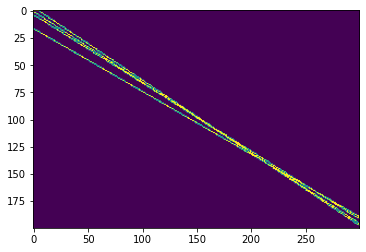

In [14]:
# ピークからθのインデックスを取り出す
idxs = np.where(peaks != 0)
peakValues = filteredVote[idxs]

print(idxs[0])
print(idxs[1])
distances = idxs[0]
thetaIndexes  =[]
for idx in idxs[1]:
    if idx >= DegreeDiscrete:# 先頭末尾を繋げた部分について、インデックスを修正する
        idx = idx - DegreeDiscrete
    thetaIndexes.append(idx)

distances = np.array(distances)
thetaIndexes = np.array(thetaIndexes)

print(distances)
print(thetaIndexes)
print("len(PX)", len(PX))
print("len(PY)", len(PY))
print("len(PR)", len(PR))
#print("len(THETA)", len(THETA))

# ピークの上位10個だけを採用する
idxs = np.argsort(peakValues)[::-1]
idxs = idxs[:10]
distances = distances[idxs]
thetaIndexes = thetaIndexes[idxs]

# 検出された直線を実際に描画して確認する
#y = -(math.cos(rad) / math.sin(rad)) * x + ((yidx[0] - diagonalDistance) / math.sin(rad))
#x = -(math.sin(rad) / math.cos(rad)) * y + ((yidx[0] - diagonalDistance) / math.cos(rad))
x = np.zeros((CANVAS_HEIGHT, CANVAS_WIDTH)).astype(np.uint8)

threshold1 = math.pi * (3/4)
threshold2 = math.pi * (1/4)
for idx, d in zip(thetaIndexes, distances):
    rad = theta_arr[idx]
    #x= -y sinθ/cosθ +ρ/ cosθ
    #x1 = 
    if rad > (threshold1) or rad < (threshold2):
        y1 = 0
        y2 = CANVAS_HEIGHT
        x1 = -(math.sin(rad) / math.cos(rad)) * y1 + ((d - diagonalDistance) / math.cos(rad))
        x2 = -(math.sin(rad) / math.cos(rad)) * y2 + ((d - diagonalDistance) / math.cos(rad))
    else:
        x1 = 0
        x2 = CANVAS_WIDTH
        y1 = -(math.cos(rad) / math.sin(rad)) * x1 + ((d - diagonalDistance) / math.sin(rad))
        y2 = -(math.cos(rad) / math.sin(rad)) * x2 + ((d - diagonalDistance) / math.sin(rad))
    print(rad, x1, x2, y1, y2)
    plotLine(x, int(x1), int(y1), int(x2), int(y2), broken=1, variance=0)
plt.imshow(x)
plt.savefig("./009_haough_convert_lines.png")
plt.show()